In [1]:
from griddify import datasets

data = datasets.get_compound_descriptors()

In [2]:
from griddify import Preprocessing

pp  = Preprocessing()
pp.fit(data)
data = pp.transform(data)

In [3]:
from griddify import FeatureDistances

fd = FeatureDistances(metric="cosine").calculate(data)

In [4]:
from griddify import Tabular2Cloud


tc = Tabular2Cloud()
tc.fit(fd)
Xc = tc.transform(fd)


/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [11]:
from griddify.plots import cloud_plot

<AxesSubplot:>

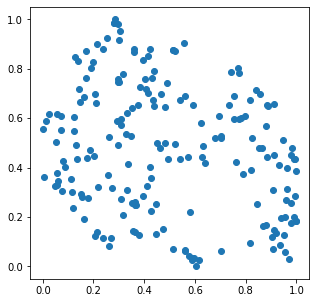

In [12]:
cloud_plot(Xc)

In [13]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

<AxesSubplot:>

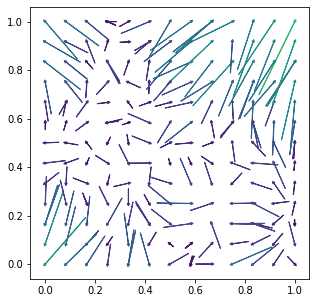

In [14]:
from griddify.plots import arrows_plot

arrows_plot(Xc, Xg, capping_distance=0.5)

In [33]:
import numpy as np
import lap
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


GRIDDIFY_METRIC = "sqeuclidean"


class Cloud2Grid(object):

    def __init__(self, max_side=128):
        self._max_side=max_side
        self._clusters=None

    def _is_cloud(self, X):
        if len(X.shape) != 2:
            return False
        if X.shape[1] != 2:
            return False
        return True

    def _find_side(self, X):
        side = int(np.sqrt(X.shape[0]))
        if side > self._max_side:
            side = self._max_side
        return side

    def _needs_downsampling(self, X):
        avail = self._side**2
        assert avail <= X.shape[0]
        if avail == X.shape[0]:
            return False
        else:
            return True

    def _downsample_with_clustering(self, X):
        self._clusters = KMeans(n_clusters=self._side**2)
        self._clusters.fit(X)
        centroids = self._clusters.cluster_centers_
        return centroids

    def _griddify(self, X):
        xv, yv = np.meshgrid(np.linspace(0, 1, self._side), np.linspace(0, 1, self._side))
        self.grid = np.dstack((xv, yv)).reshape(-1, 2)
        cost = cdist(self.grid, X, GRIDDIFY_METRIC)
        cost = cost * (1000000 / cost.max())
        cost = cost.astype(int)
        min_cost, row_assigns, col_assigns = lap.lapjv(cost)
        self._grid_jv = self.grid[col_assigns]
        self._min_cost = min_cost
        self._row_assigns = row_assigns
        self._col_assigns = col_assigns

    def _grid_coordinates_as_integers(self, X):
        d = dict((v, i) for i, v in enumerate(np.linspace(0, 1, self._side)))
        Xt = np.zeros(X.shape, dtype=int)
        for i in range(X.shape[0]):
            Xt[i] = [d[X[i,0]], d[X[i,1]]]
        return Xt

    def fit(self, X):
        assert self._is_cloud(X)
        self._side = self._find_side(X)
        self._do_cluster = self._needs_downsampling(X)
        if self._do_cluster:
            X = self._downsample_with_clustering(X)
        self._griddify(X)
        self.nearest_neighbors = NearestNeighbors(n_neighbors=1)
        self.nearest_neighbors.fit(X)

    def transform(self, X, as_integers=False):
        assert self._is_cloud(X)
        idxs = self.nearest_neighbors.kneighbors(X, return_distance=False)[:,0]
        X_grid = np.zeros((X.shape[0], 2))
        for i, idx in enumerate(idxs):
            X_grid[i] = self._grid_jv[idx]
        if as_integers:
            return self._grid_coordinates_as_integers(X_grid)
        else:
            return X_grid

    def get_mappings(self, X):
        X = self.transform(X, as_integers=True)
        mappings = np.zeros((self._side, self._side), dtype=int)
        for i in range(X.shape[0]):
            mappings[X[i,0], X[i,1]] = i
        return mappings


cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
mappings = cg.get_mappings(Xc)

/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:



import numpy as np


class Flat2Grid(object):

    def __init__(self, mappings):
        self._mappings = mappings
        self._get_inverse_mappings()
    
    def _get_inverse_mappings(self):
        self._inverse_mappings = {}
        for i in range(self._mappings.shape[0]):
            for j in range(self._mappings.shape[1]):
                self._inverse_mappings[self._mappings[i,j]] = (i,j)

    def transform(self, X):
        Xt = np.array((X.shape[0], self._mappings.shape[0], self._mappings.shape[1]))
        for i in range(X.shape[0]):
            x = X[i,:]
            for j, v in enumerate(x):
                idx_i, idx_j = self._inverse_mappings[j]
                Xt[i, idx_i, idx_j] = v
        return np.array(Xt)

tg = Flat2Grid(mappings)
tg.fit(Xg)

AttributeError: 'Cloud2Grid' object has no attribute 'shape'

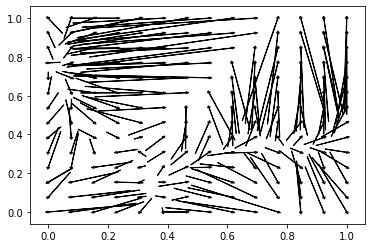

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Xc)
Xc = scaler.transform(Xc)

for start, end in zip(Xc, Xg):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

array([[0.69230769, 0.        ],
       [1.        , 0.84615385],
       [1.        , 0.15384615],
       [0.92307692, 0.23076923],
       [0.92307692, 0.30769231],
       [0.84615385, 0.07692308],
       [0.76923077, 0.53846154],
       [0.76923077, 0.23076923],
       [0.76923077, 0.07692308],
       [0.76923077, 0.30769231],
       [0.69230769, 0.23076923],
       [0.69230769, 0.53846154],
       [0.69230769, 0.61538462],
       [0.69230769, 0.69230769],
       [0.84615385, 0.84615385],
       [0.84615385, 0.69230769],
       [0.30769231, 0.76923077],
       [0.84615385, 0.61538462],
       [0.92307692, 0.07692308],
       [0.92307692, 0.61538462],
       [0.84615385, 0.        ],
       [0.92307692, 0.        ],
       [1.        , 0.23076923],
       [1.        , 0.        ],
       [0.76923077, 1.        ],
       [1.        , 0.76923077],
       [0.53846154, 0.30769231],
       [0.53846154, 0.38461538],
       [0.61538462, 0.23076923],
       [0.38461538, 0.30769231],
       [0.